This model is taken from this [source](https://homepages.inf.ed.ac.uk/rsarkar/papers/periodic.pdf). It defines a model of discrete signals with approximately periodic sequences embedded in them. It includes a periodic component with probabilistic inter-event time, and a Poisson process modeling the aperiodic false positive noise events. 

Let $y_{1:n} = y_1, y_2, ..., y_n$ be our observed periodic signal. This can be decomposed into the following two components: 

- A sequence of periodic events $x_{i}$ where $x_{i+1} = N(x_i + T, \sigma)$. Each signal event displays periodicity of time, $T$, along with gaussian noise parameterised by variance $\sigma^2$.
- A sequence of noise events $z_i$ where $z_{i+1} = z_i + \delta$, and $\delta$ follows an exponential distribution with an expectation of $\frac{1}{\lambda}$, for a rate parameter $\lambda > 0$. This component takes into account noise attributed with the signal reading that can come from the signal itself or the instrument used to detect the signal. 

The model would be able to tell us the periodicity of the signal, $T$, along with $\sigma$ and $\lambda$ in order to characterise the level of noise in the system. 

Let's first make the test data that will be used to validate our model. Some test cases that we can consider are: 

1. Just noise, no periodic signal: Can the model correctly identify that there is no signal?
2. Strict periodic signal with no noise: baseline, the model should be able to correctly infer the peridicity of the signal with 100% certainty. 
3. Signal with probabilistic period.
4. Periodic signal with phase drift. 
5. Periodic signal with random false positives.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
SEED = 42 

Now that we have created our test data, let's implement the actual model. We will try and keep the variable naming consistent with the original [paper](https://homepages.inf.ed.ac.uk/rsarkar/papers/periodic.pdf). 

$$h_n = [T, \sigma^2, \lambda, \hat{z_i}^j, \hat{x_i}^j]^T$$

where $i$ is the $i$ th timestep, and $j$ refers to the $j$ th particle that we have sampled, and: 
- T : period of signal
- $\sigma$ : standard deviation for Gaussion distribution of period variability. 
- $\lambda$ : Rate of false positive noise events.
- $\hat{z}$ : Latest event timestep marked as a noise event.
- $\hat{x}$ : Latest event timestep marked as a periodic event. 

Each observed signal value $y_i$ can be classified as either the periodic signal or false positive noise. The model will therefore use variable $r_i$ where:
$r_i = 1$ if $y_i$ originates from the periodic process, $r_i = 0$ otherwise. 

### 1. Likelihood functions for signal, $L = p(y_i | h_i)$
$L = p(y_i | h_i) = \sum_{r \in {0,1}}p(y_i, r_i | h_i)$

Let's inspect the first component of the summation when $r_i = 1$. This component is the likelihood of the signal when it is generated by the periodic signal process. 

$p(y_i, r_i = 1 | h_i) = p(y_i | h_i, r_i = 1)p(r_i = 1)$

and $p(y_i | h_i, r_i = 1)$ refers to the likelihood of the signal given it is generated by the periodic signal process. As mentioned above, we model this using Gaussian distribution centered about the timestamp of the last identified signal process offset by the period, $x_{i-1} + T_i$, with noise $\sigma_i$:

$p(y_i | h_i, r_i = 1) = N(T_i + \hat{x}_{i-1}, \sigma_i)$

The term $p(r_i = 1)$ refers to the probability of $y_i$ not being a noise event. 

This is equivalent to: $1 - p(r_i = 0)$

Given the false positive signal generation process follows a Poisson distribution, $p(r_i = 0)$ is equivalent to the probability that $y_i$ is the first noise process to be identified between the last identified false positive $z_{i-1}$ and $y_i$. The time between poission events is modelled by the exponential distribution, and the CDF of said distribution is $F(x) = 1 - exp(-\lambda x)$. Hence, $1 - F(x) = exp(\lambda x)$

$$1 - p(r_i = 0) = 1 - F(y_i - z_{i-1}; exp(\lambda_i)) = exp(\lambda (y_i - z_{i-1}))$$ 

Now, let's inspect the second term of the summation when $r_i = 0$. This component is the likelihood of the signal when it is a false positive generated by noise. By definition of conditional probabilities, this can be rewritten as below: 

$$p(y_i, r_i = 0 | h_i) = p(y_i | r_i = 0, h_i) p(r_i = 0)$$

We already have the second term, modelled by an exponential distribution $f_{\exp}(x) = \lambda exp(-\lambda x)$. 

The first term is equivalent to the probability of no peridic signal event being detected between the last detected signal timestamp, $\hat{x}_i$, and current signal timestamp $y_i$. This is approximated by the complementary cumulative density of periodic events between $\hat{x}_i$ and $y_i$ - $1 - \Phi(T_i + \hat{x}_{i-1}, \sigma_i)$, where $\Phi(x) = P(X < x)$ is the Gaussian CDF. 

### 2. Hypothesis Updates
Given our set of hypothesis in the algorithm's previous iteration, $h_{i-1}$, we now want to update them according to our prior over state changes, $p(h_i | h_{i-1})$.

Each parameter contained in the Particle $h^{j}_{i}$ is sampled acacording to a Cauchy distribution centered around the previous parameter value. Taking parameter, $T$, as an example, $T_{i} \sim Cauchy(T_i, s)$ where $s$ is a tuneable parameter. The same follos for $\sigma$ and $\lambda$. 

Parameters $\hat{z}_{i-1}$ and $\hat{x}_{i-1}$ are updated differently depending on the likelihood of $y_i$ being a false positive or not: $p(r_i | y_i, h_i)$. We can sample $r_i$ from this binomial distribution and update $\hat{z}_{i-1}$ and $\hat{x}_{i-1}$ accordingly: 

If $r_i = 1$, $\hat{x}_{i} = y_i$ and $\hat{z}_{i} = \hat{z}_{i-1}$. 

If $r_i = 0$, $\hat{x}_{i} = \hat{x}_{i-1}$ and $\hat{z}_{i} = y_i$

We are able to calculate this distribution as below in terms of likelihod functions we already know: 

$p(r_i | h_i, y_i) = \frac{p(r_i, y_i | h_i)}{p(y_i | h_i)} = \frac{p(ri, y_i | h_i)}{p(y_i, r_i = 0 | h_i) + p(y_i, r_i = 1 | h_i)}$

In [8]:
class ModelDebugInfo():
    
    def __init__(self):
        self.h_series = [] # particles
        self.L_series = [] # likelihood weights
        

In [148]:
import numpy as np
from enum import Enum
from dataclasses import dataclass
from typing import ClassVar 
from scipy.stats import norm, expon


@dataclass
class Config:
    '''
    Configuration object for periodicity particle filter
    Args: 
        signal: the signal to be analyse
        num_particles: number of particles to use
        prior_T_scale: the hyperparameter to be used for the exponential distribution 
        that is used as the prior distribution for period T. 
        prior_lambda_scale: the hyperparameter to be used for the exponential distribution 
        that is used as the prior distribution for noise event rate Lambda.
        x_0: initial value for periodic event variable
        z_0: initial value for noise event variable
        cauchy_scale: scale parameter for cauchy distribution used as the hypothesis distribution
    '''
    signal : list
    num_particles : int = 50
    prior_T_scale : float = 1.0
    prior_lambda_scale : float = 1.0
    x_0: float = 0.0 
    z_0: float = 0.0
    cauchy_scale : float = 1.0

    def __post_init__(self):
        self.num_timesteps = len(self.signal)

@dataclass
class Particles:
    '''
    Dataclass for carrying around each variable defined in particle vector 
    h = [T, lambda, sigma, xhat, zhat]^t. 
    
    Args: 
        T: 
        Lambda: Rate parameter for false positive signals due to noise. 
        Sigma:
        X: timestamp of last identified signal generated by periodic signal process
        Z: timestamp of last identified signal generated by false positive noise process
        NumParticles: defaults to length of parameter vectors. Executes length typecheck. 
    '''
    ### public ###
    T : "np.ndarray"
    Lambda : "np.ndarray"
    Sigma : "np.ndarray"
    X : "np.ndarray"
    Z : "np.ndarray"
    NumParticles : int

    ### private class var ###

    # number of params we use in our model
    _NumParams : ClassVar[int] = 5

    class VariableIndex(Enum):
        T = 0
        Lambda = 1
        Sigma = 2
        X = 3
        Z = 4

    def __post_init__(self):
        self._assert_ctor_params_ndarray()
        self._assert_ctor_params_same_len()
        
    def _assert_ctor_params_ndarray(self):
        '''enforce type checking as a simple list does not support broadcasting
        user must provide numpy arrays'''
        assert isinstance(self.T, np.ndarray), "T is not a numpy array"
        assert isinstance(self.Lambda, np.ndarray), "Lambda is not a numpy array"
        assert isinstance(self.Sigma, np.ndarray), "Sigma is not a numpy array"
        assert isinstance(self.X, np.ndarray), "X is not a numpy array"
        assert isinstance(self.Z, np.ndarray), "Z is not a numpy array"

    def _assert_ctor_params_same_len(self):
        
        is_same_len = (len(self.T)  \
                      == len(self.Lambda) \
                      == len(self.Sigma) \
                      == len(self.X) \
                      == len(self.Z) \
                      == self.NumParticles)
        
        assert is_same_len, f"Input vectors are not of the same size. Size specified is {self.NumParticles}"
       

    def __len__(self):
        return self.NumParticles 

    def __eq__(self, other):
        return  np.array_equal(self.T, other.T) \
                and np.array_equal(self.Lambda, other.Lambda) \
                and np.array_equal(self.Sigma, other.Sigma) \
                and np.array_equal(self.X, other.X) \
                and np.array_equal(self.Z, other.Z)

    @staticmethod 
    def _indexing_key_typecheck(key):
        if not (isinstance(key, int) or isinstance(key, slice) or isinstance(key, np.ndarray)):
            raise TypeError(f"Particles object behaves as a 1-D array or list. Invalid index of type {type(key)}")

    def _indexing_out_of_bounds_check(self, key):
        if (isinstance(key, slice)): 
            if key.stop > self.NumParticles - 1:
                raise IndexError(f"Particles object contains {self.NumParticles} particles. Cannot retrieve items for indices {key.start}:{key.stop}")

        elif isinstance(key, int):
            if (key > self.NumParticles -1):
                raise IndexError(f"Particles object contains {self.NumParticles} particles. Cannot retrieve items for index {key}")

    def __getitem__(self, key):
        self._indexing_key_typecheck(key)
        self._indexing_out_of_bounds_check(key)

        t = self.T[key]
        l = self.Lambda[key]
        s = self.Sigma[key]
        x = self.X[key]
        z = self.Z[key]

        if isinstance(key, int):
            N = 1
            # input needs to be np array
            t, l, s, x, z = np.array([t]), np.array([l]), np.array([s]), np.array([x]), np.array([z])
        else:
            N = len(t)

        return Particles(t, l, s, x, z, N)

    def __setitem__(self, key, value:"Particles"):
        self._indexing_key_typecheck(key)
        self._indexing_out_of_bounds_check(key)

        if not isinstance(value, Particles):
            raise TypeError(f"Value to be set should be Particles object, not {type(value)}")

        self.T[key] = value.T 
        self.Lambda[key] = value.Lambda 
        self.Sigma[key] = value.Sigma 
        self.X[key] = value.X 
        self.Z[key] = value.Z 

    def __delitem__(self, key):
        self._indexing_key_typecheck(key)
        self._indexing_out_of_bounds_check(key)
        self.T.__delitem__(key)
        self.Lambda.__delitem__(key)
        self.Sigma.__delitem__(key)
        self.X.__delitem__(key)
        self.Z.__delitem__(key)

    def __iter__(self):
        for idx in range(self.NumParticles):
            yield Particles(self.T[idx], 
                            self.Lambda[idx], 
                            self.Sigma[idx], 
                            self.X[idx], 
                            self.Z[idx])

    @property
    def shape(self):
        return (self._NumParams, self.NumParticles)

    @property
    def X_last(self):
        return self._X_last

    @X_last.setter
    def X_last(self, val):
        '''enforce type checking as a simple list does not support broadcasting
        user must provide numpy arrays'''
        assert isinstance(val, np.ndarray), "X_last is not a numpy array"
        self._X_last = val 

    @property
    def Z_last(self):
        return self._Z_last

    @Z_last.setter
    def Z_last(self, val):
        '''enforce type checking as a simple list does not support broadcasting
        user must provide numpy arrays'''
        assert isinstance(val, np.ndarray), "X_last is not a numpy array"
        self._Z_last = val

    def as_matrix(self):
        '''Return np.ndarray of vector h = [T, lambda, sigma, xhat, zhat]^t
        of shape (5, num_particles)'''
        return np.stack((self.T, self.Lambda, self.Sigma, self.X, self.Z))

debugInfo = ModelDebugInfo() 

class PeriodicityParticleFilter:
    def __init__(self, config:Config):
        self.config = config
        self.y = config.signal
        self.num_timesteps = self.config.num_timesteps
        self.K = self.config.num_particles
        self.s_T = self.config.prior_T_scale 
        self.s_lambda = self.config.prior_lambda_scale
        self.s_cauchy = self.config.cauchy_scale

        self._h = None
        self._iter_cnt = 0

    def signal(self):
        '''
        Generator method for iterating through the signal. 
        Returns the next value in the signal. 
        '''
        while self._iter_cnt < self.num_timesteps: 
            yield self.y[self._iter_cnt]
            self._iter_cnt += 1

    def initialise_samples(self) -> Particles:
        '''
        Sample K particles from prior distributions for h_0
        h = [T, lambda, sigma, x_0, z_0] 
        where: 
            T ~ exponential(scale) 
            lambda ~ exponential(scale)
            sigma ~ Uniform(0, T)
            x_0 = zero
            z_0 = zero
        '''
        T_0 = np.random.exponential(self.s_T, self.K)
        lambda_0 = np.random.exponential(self.s_lambda, self.K) 
        sigma_0 = np.random.rand(self.K) * T_0
        x_0 = np.zeros(self.K)
        z_0 = np.zeros(self.K) 
        return Particles(T_0, lambda_0, sigma_0, x_0, z_0, self.K)

    @staticmethod
    def sample_cauchy_1D(loc, scale):
        hnew_std = np.random.standard_cauchy(len(loc))
        hnew = scale * hnew_std + loc 
        return hnew

    def sample_event_provenance(self, y, h:Particles):
        '''
        Sample event provenance r_i. 
        Args: 
            h: Particles object, containing particles (or hypotheses) used in our model.

        Returns: 
            r: r values sampled from bernoulli distribution. Size is equal to number of 
            particles. 

        Calculate bernoulli distribution, p(r_i = val | y_i, h_i), using conditional probabilities:

        p(ri = 1 | yi, hi) = PeriodicSignalLikelihood / (PeriodicSignalLikelihood + FalsePositiveLikelihood)
        p(ri = 0 | yi, hi) = 1 - p(ri = 1 | yi, hi)
        '''
        
        logps = self.get_periodic_likelihood(y, h)
        logfp = self.get_false_positive_likelihood(y, h)

        # p = ps / (ps + fp)
        logp = logps - np.logaddexp(logps, logfp)
        
        # single trial binomial = bernoulli
        N = 1 
        r = np.random.binomial(N, np.exp(logp))

        return r
        

    def update_hypothesis(self, y, h:Particles):
        '''
        Sample next set of particles from hypothesis distribution p(h_i|h_{i-1}).
        For the ith timestep, let j denote the jth particle:
        h^j = [T^j, lambda^j, sigma^j, x_j, z_j]

        where each variable in vector h_j are sampled from a cauchy distribution centred
        about the previous particle value. 
        '''
        # sample T, lambda, sigma from cauchy
        # hnew_std = np.random.standard_cauchy() # scale = s, mean = 0
        # hnew = self.s_cauchy * hnew_std + h # scale = s, mean = h
        # take absolute value as these params need to be > 0
        h.T = np.abs(self.sample_cauchy_1D(h.T, self.s_cauchy))
        h.Sigma = np.abs(self.sample_cauchy_1D(h.Sigma, self.s_cauchy))
        h.Lambda = np.abs(self.sample_cauchy_1D(h.Lambda, self.s_cauchy))

        rsampled = self.sample_event_provenance(y, h)
        r_is_1_idx, r_is_0_idx = np.nonzero(rsampled), np.nonzero(1-rsampled)
        h.X[r_is_1_idx] = y 
        h.Z[r_is_0_idx] = y 
        
        return h

    def get_periodic_likelihood(self, y, h:Particles):
        '''
        The likelihood of the signal being generated by the signal process. 
        Returns log likeliood for floating point precision stability. 

        L = p(yi, ri=1|hi) = p(yi | hi, ri = 1) x (1 - p(ri = 0)) 
        = N(Ti + x_{i-1}, sigma_i) * (1 - F(yi - z_{i-1}; exp(lambda_i)))

        Args: 
            y : ith event timestamp
            h : particle object containing current parameter hypotheses 
        '''
        
        # p(yi | hi, ri=1) = N(Ti + x_{i-1}, sigma_i)
        # scale = standard deviation, not variance.
        logp1 = norm.logpdf(y, h.T + h.X, h.Sigma)
        
        # 1 - F(yi - z_{i-1}; exp(lambda_i)); F_exp(x; lambda) = 1 - exp(-lamba * x)
        # therefore, 1 - F(yi - z_{i-1}; exp(lambda_i)) = exp(-lambda * (yi - z_{i-1}))
        logp2 = -h.Lambda * (y - h.Z)

        return logp1 + logp2 

    def get_false_positive_likelihood(self, y, h:Particles):
        '''
        The likelihood of the signal being a false positive generated by noise. 
        Returns log likeliood for floating point precision stability. 

        L = p(yi, ri = 0 | hi) = p(i | hi, ri = 0) x p(ri = 0) 
        = f(yi - z_{i-1}; exp(lambda_i)) * (1 - F(yi; N(x_{i-1} + Ti, sigma_i)))

        Args: 
            y: ith event timestamp
            h: particle object containing current parameter hypotheses. 
        '''
        # f(yi - z_{i-1}; exp(lambda_i)), expon takes parameter scale = 1/lambda
        logp1 = expon.logpdf(y - h.Z, scale=1/h.Lambda)
        
        # 1 - Phi(y; x_{i-1} + Ti, sigma_i)
        # p2 = 1 - norm.cdf(y, loc = h.T + h.X, scale = h.Sigma)
        # survival function sf = 1 - cdf. 
        logp2 = norm.logsf(y, loc = h.T + h.X, scale = h.Sigma)

        return logp1 + logp2

    def log_likelihood_weighting(self, y, h:Particles):
        '''
        Returns likelihood weighting for each particle. 

        '''
        # Lper = p(yi, ri=1 | hi)
        LogLperiodic = self.get_periodic_likelihood(y, h)

        # Lfp = p(yi, ri0 | hi)
        LogLfp = self.get_false_positive_likelihood(y, h)

        # L = p(yi | hi) = p(yi, ri=0 | hi) + p(yi, ri=1 | hi)
        # Use LogL = Log(exp(LogX) + exp(LogY))
        # LogL = LogX + Log(1 + exp(Log(Y) - Log(X))) is better if 
        # LogX is kept to be the larger value than LogY for better behaviour with -infs. 
        LogL = np.logaddexp(LogLperiodic, LogLfp) 
        
        return LogL

    def resample_particles(self, h:Particles, w:np.ndarray):
        '''
        Resample particles, h, with probabilities according to their likelihood weights, w. 
        The number of particles resampled, k, is equal to the number of particles present in the 
        Particles object (equivalent to len(h)). k is equivalent to self.K, or config.num_particles. 

        Args: 
            h: Particles object
            w: np.array of length equal to the number of particles
        
        Raises ValueError if length of w does not equal to the number of particles. 
        Raises ValueError if length of h is not equal to self.K (which is eqv to config.num_particles).
        '''
        num_h = len(h)

        if (num_h != len(w)):
            msg = "Number of particles must match length of array of weights." + \
                f"Received Particles object of length {num_h} but likelihood weights given is " + \
                    f"of length {len(w)}"
            raise ValueError(msg)

        if (num_h != self.K):
            msg = f"Number of particles specified for this model is {self.K}, but Particles object" + \
                f" given has {num_h} particles."
            raise ValueError(msg)

        idx = np.random.choice(a=num_h, size=num_h, replace=True, p=w)
        h = h[idx]

        return h 

    def fit(self):
        '''Run the particle filter on the input data.'''

        # initialise K particles by sampling from prior distributions 
        # over hypothesis parameters. 
        self._h = self.initialise_samples()

        for y in self.signal(): 
            # sample next set of particles from hypothesis distribution p(h_i|h_{i-1})
            self._h = self.update_hypothesis(y, self._h)
            debugInfo.h_series.append(self._h)

            # likelihood weighting - compute likeliness of each particle
            loglw = self.log_likelihood_weighting(y, self._h)

            # normalise likelihood weights
            # To prevent overflow, we do the following transformation:
            # We need to remind ourselves that resampling is done based on 
            # relative weight sizes. 
            # So, we subtract the max(log-likelihood) i.e. equiv to likelihood / max(likelihood) 
            # then we convert back from log domain to normalise weights. 
            rel_loglw = loglw - max(loglw)
            lw = np.exp(rel_loglw)
            lw_norm = lw / np.sum(lw)

            debugInfo.L_series.append(lw_norm)

            # resample
            self._h = self.resample_particles(self._h, lw_norm)

        return self._h


# Tests

## Unit Tests

In [78]:
### unit tests ### 

# Test particle ctor
def test_nd_array_check():

    def _check(T, Lambda, sigma, xlast, zlast, N, expectedmsg):
        try: 
            example_h = Particles(T, 
                                  Lambda, 
                                  sigma, 
                                  xlast,
                                  zlast,
                                  N) 
        except AssertionError as e:
            expected = str(e) == expectedmsg
            if not expected: 
                raise AssertionError(f"Expected error message: '{expectedmsg}' but received {str(e)}")
            return 

        raise AssertionError("Input type check for np.ndarray did not trigger an assertion error." + 
                             f" Expected to see error msg: {expectedmsg}")

    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([100, 100, 100, 100])
    example_Z_last = np.array([0, 0, 0, 0])
    N = 4
    
    expectedmsg = "T is not a numpy array"
    _check(list(example_T), example_lambda, example_sigma, example_X_last, example_Z_last, N, expectedmsg)

    expectedmsg = "Lambda is not a numpy array"
    _check(example_T, list(example_lambda), example_sigma, example_X_last, example_Z_last, N, expectedmsg)

    expectedmsg = "Sigma is not a numpy array"
    _check(example_T, example_lambda, list(example_sigma), example_X_last, example_Z_last, N, expectedmsg)

    expectedmsg = "X is not a numpy array"
    _check(example_T, example_lambda, example_sigma, list(example_X_last), example_Z_last, N, expectedmsg)

    expectedmsg = "Z is not a numpy array"
    _check(example_T, example_lambda, example_sigma, example_X_last, list(example_Z_last), N, expectedmsg)


def test_arr_length_check():
    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([100, 100, 100])
    example_Z_last = np.array([0, 0, 0])
    N = 4
    
    try: 
        example_h = Particles(example_T, 
                            example_lambda, 
                            example_sigma, 
                            example_X_last,
                            example_Z_last,
                            N)
    except AssertionError as e:
        expectedmsg = ""
        expected = str(e) == expectedmsg
        if expected: 
            raise AssertionError(f"Expected error message: '{expectedmsg}' but received {str(e)}")
        return

    raise AssertionError("input length check did not trigger an assertion error")

def test_len():
    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([100, 100, 100, 100])
    example_Z_last = np.array([0, 0, 0, 0])
    N = 4

    example_h = Particles(example_T, 
                        example_lambda, 
                        example_sigma, 
                        example_X_last,
                        example_Z_last,
                        N)

    assert len(example_h) == N, f"Expected len(Particle) to return {N}, but got {len(example_h)} instead"

def test_shape():
    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([100, 100, 100, 100])
    example_Z_last = np.array([0, 0, 0, 0])
    N = 4

    example_h = Particles(example_T, 
                        example_lambda, 
                        example_sigma, 
                        example_X_last,
                        example_Z_last,
                        N)

    expected_shape = (5, N)
    assert example_h.shape == expected_shape, f"Expected Particle.shape property to return {expected_shape}, " + \
                                              f"but got {example_h.shape} instead"

def test_as_matrix():
    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([100, 100, 100, 100])
    example_Z_last = np.array([0, 0, 0, 0])
    N = 4

    example_h = Particles(example_T, 
                        example_lambda, 
                        example_sigma, 
                        example_X_last,
                        example_Z_last,
                        N)

    h_mat = example_h.as_matrix()

    assert h_mat.shape == (5, N), f"as_matrix() method returned a matrix of shape {h_mat.shape}. " + \
        f"Expected shape of {(5,N)}"

    expected = np.stack((example_T, example_lambda, example_sigma, example_X_last, example_Z_last))

    assert np.array_equal(h_mat, expected), "as_matrix() returned a value that was not expected."

def test_particle_eq():

    t = np.array(range(0,10))
    l = np.array(range(0,10)) * 2 # multiply just to differentiate values for each var 
    s = np.array(range(0,10)) * 3
    x = np.array(range(0,10)) * 4 
    z = np.array(range(0,10)) * 5

    h1 = Particles(t, l, s, x, z, len(t))
    h2 = Particles(t, l, s, x, z, len(t))

    assert h1 == h2, f"Test case 1: __eq__ method check returned False when True was expected."

    t = np.array(range(0,10)) * 100
    l = np.array(range(0,10)) * 2 # multiply just to differentiate values for each var 
    s = np.array(range(0,10)) * 3
    x = np.array(range(0,10)) * 4 
    z = np.array(range(0,10)) * 5

    h3 = Particles(t, l, s, x, z, len(t))

    assert h1 != h3, f"Test case 2: __eq__ method check returned True when False was expected."

    t = np.array([1])
    l = np.array([1])
    s = np.array([1])
    x = np.array([1])
    z = np.array([1])
    h4 = Particles(t, l, s, x, z, 1)
    h5 = Particles(t, l, s, x, z, 1)

    assert h4 != h1, "Test case 3: __eq__ method check returned True when False was expected."
    assert h4 != h2, "Test case 4: __eq__ method check returned True when False was expected."
    assert h4 != h3, "Test case 5: __eq__ method check returned True when False was expected."
    assert h4 == h5, f"Test case 6: __eq__ method check returned False when True was expected."


def test_particle_getitem():
    N = 10
    t = np.array(range(0,N))
    l = np.array(range(0,N)) * 2 # multiply just to differentiate values for each var 
    s = np.array(range(0,N)) * 3
    x = np.array(range(0,N)) * 4 
    z = np.array(range(0,N)) * 5

    h = Particles(t, l, s, x, z, len(t))

    # test out of index for integer index 
    try: 
        M = N + 100
        h[N]
        raise AssertionError(f"Expected Particles[{M}] to raise IndexError as Particles " + \
            f"object contains {M} particles, but no IndexError was raised")
    except IndexError as e: 
        pass 

    # test out of index for slice
    try: 
        sidx, eidx = int(N/2), N + 100
        h[sidx:eidx]
        raise AssertionError(f"Expected Particles[{sidx}:{eidx}] to raise IndexError as Particles " + \
            f"object contains {M} particles, but no IndexError was raised")
    except IndexError as e:
        pass 

    # test integer index 
    for i in range(-3, N):
        expected = Particles(np.array([t[i]]), 
                             np.array([l[i]]), 
                             np.array([s[i]]), 
                             np.array([x[i]]), 
                             np.array([z[i]]), 
                             1)
        msg = f"{i}: Expected {h[i]} to be equal to {expected} but __eq__ returned False"
        assert h[i] == expected,  msg

    sidx = 0
    eidx = 3
    expected = Particles(np.array(t[sidx:eidx]), 
                         np.array(l[sidx:eidx]), 
                         np.array(s[sidx:eidx]), 
                         np.array(x[sidx:eidx]), 
                         np.array(z[sidx:eidx]),
                         eidx - sidx)
    got = h[sidx:eidx]
    assert got == expected, f"Expected {expected} but received {got} for Particles[{sidx}:{eidx}]"

    sidx = -3
    eidx = -1
    expected = Particles(np.array(t[sidx:eidx]), 
                         np.array(l[sidx:eidx]), 
                         np.array(s[sidx:eidx]), 
                         np.array(x[sidx:eidx]), 
                         np.array(z[sidx:eidx]),
                         2)
    got = h[sidx:eidx]
    assert got == expected, f"Expected {expected} but received {got} for Particles[{sidx}:{eidx}]"

def test_particle_setitem():
    N = 10
    t = np.ones(N)
    l = np.ones(N)
    s = np.ones(N)
    x = np.ones(N)
    z = np.ones(N)

    h = Particles(t, l, s, x, z, len(t))

    # set single index
    arr = np.ones(N)
    for idx in range(-3,N):
        h[idx] = Particles(np.zeros(1),np.zeros(1),np.zeros(1),np.zeros(1),np.zeros(1),1)
        arr[idx] = 0
        expected = Particles(arr, arr, arr, arr, arr, N)
        assert h == expected, f"Expected {expected} but got {h} when setting Particles[{idx}]"

        assert np.array_equal(h.T, arr), f"Expected h.T to give {arr} but got {h.T}"
        assert np.array_equal(h.Lambda,arr), f"Expected h.Lambda to give {arr} but got {h.Lambda}"
        assert np.array_equal(h.Sigma,arr), f"Expected h.Sigma to give {arr} but got {h.Sigma}"
        assert np.array_equal(h.X,arr), f"Expected h.X to give {arr} but got {h.X}"
        assert np.array_equal(h.Z,arr), f"Expected h.Z to give {arr} but got {h.Z}"

    # set using slice
    t = np.ones(N)
    l = np.ones(N)
    s = np.ones(N)
    x = np.ones(N)
    z = np.ones(N)

    h = Particles(t, l, s, x, z, len(t)) # reset 
    sidx, eidx = 3,6
    n = eidx - sidx 
    tmp = np.ones(n) * 100
    h[sidx:eidx] = Particles(tmp, tmp, tmp, tmp, tmp, n)
    arr = np.ones(N)
    arr[sidx:eidx] = 100

    assert np.array_equal(h.T, arr), f"Expected h.T to give {arr} but got {h.T}"
    assert np.array_equal(h.Lambda,arr), f"Expected h.Lambda to give {arr} but got {h.Lambda}"
    assert np.array_equal(h.Sigma,arr), f"Expected h.Sigma to give {arr} but got {h.Sigma}"
    assert np.array_equal(h.X,arr), f"Expected h.X to give {arr} but got {h.X}"
    assert np.array_equal(h.Z,arr), f"Expected h.Z to give {arr} but got {h.Z}"

    # set usng slice with neatices 

def test_particle_container_properties():
    test_particle_eq()
    test_particle_getitem()
    test_particle_setitem()

test_particle_container_properties()

In [79]:
import scipy

### unit tests ## 

# Test function - get_periodic_likelihood

def test_periodic_likelihood_no_noise():
    '''
    Test case: 

    Let's have the signal as strictly periodic where the true
    period T = 100;
    
    i.e. signal timestamps = 0, 100, 200, 300, 400, 500,...

    Here, true lambda = 0 (rate of false positive = 0 as we have none)
    and true sigma = 0 (signal is strictly periodic with no uncertainty)

    For our particle vector h = [T, lambda, sigma, X, Z], let's have the following samples: 

    For this test case, y_{i-1} = 100, y_i = 200

    particles for test scenario: 

    h1 = [T = 100, lambda = 0, sigma = 0, x_last = 100, z_last = 0]
    This should return NaN. T = 100 is correct with zero uncertainty. sigma=0, so gaussian pdf 
    would have an infinite pdf value. Lambda = 0 so correct that we have no noise, and we also
    correctly know no noise has been found yet, z_last = 0. 

    h2 = [T = 100, lambda = 0, sigma = 0.01, x_last = 100, z_last = 0]
    Same as test 1, but now with non-zero uncertainty. This should return a non-NaN likelihood value 
    as the gaussian no longer has a divide by zero. Exact value is: 39.89422804
    
    h3 = [T = 1, lambda = 0, sigma = 0.01, x_last = 100, z_last = 0]
    T is way off, with small uncertainty. x_last = 100 while current value is 200. 
    This means likelihood of the observation generated by a periodic signal according to particle h3 is zero. 
    Again, noise process param lambda is set to zero. 

    h4 = [T = 90, lambda = 0, sigma = 25, x_last = 100, z_last = 0]
    T is a bit off, but sigma = 25 so that actual T falls within 1 std dev of our estimate. 
    Likelihood should be moderate value. Actual value is 0.014730805
    '''
    y_prev = 100
    y_curr = 200
    example_T = np.array([100, 100, 1, 90])
    example_lambda = np.array([0, 0, 0, 0])
    example_sigma = np.array([1e-19, 0.01, 0.01, 25])
    example_X_last = np.array([y_prev, y_prev, y_prev, y_prev])
    example_Z_last = np.array([0, 0, 0, 0])
    
    example_h = Particles(example_T, 
                         example_lambda, 
                         example_sigma, 
                         example_X_last,
                         example_Z_last,
                         4) # Z_curr not used in priodic likelihood so just set to zero

    # initialisation does not matter, we're just testing the get_periodic_likelihood func. 
    particle_filter = PeriodicityParticleFilter(Config([]))

    p = particle_filter.get_periodic_likelihood(y_curr, example_h)

    p1, p2, p3, p4 = p 
    p1_expected, p2_expected, p3_expected, p4_expected = 18.6, 39.9, 0, 0.014731

    assert np.round(np.log10(p1), 1) == p1_expected, f"Expected {p1_expected} for test case 1, but received {p1}"
    assert np.round(p2, 1) == p2_expected, f"Expected {p2_expected} for test case 2, but received {p2}"
    assert np.round(p3, 12) == p3_expected, f"Expected {p3_expected} for test case 3, but received {p3}"
    assert np.round(p4, 6) == p4_expected, f"Expected {p4_expected} for test case 4, but received {p4}"


def test_periodic_likelihood_with_noise():
    '''
    Test case: 

    Let's have the signal as periodic where the true period T = 100,
    with noise that occurs within 25 time units. Example signal could look like:
    
    i.e. signal timestamps = 0, 10, 100, 117, 200, 214, 300, 313, 400, 415, 500,...

    For our particle vector h = [T, lambda, sigma, X, Z], let's have the following samples: 

    h1 = [T = 100, lambda = ln(2)/100, sigma = 1E-19, x_last = 200, z_last = 114]
    We set the particle T = 100 and sigma = 1E-19 - i.e. this particle is close to the actual true signal
    parameters. We should get a zero value for the peridic series likelihood as the parameters indicate we are most certain
    that the period of the true signal is 100 with almost zero uncertainty, therefore 214 being a true signal is impossible. 
    We've set the current and last noise signal times to be 114 and 214; we set the lambda to ln(2)/100 such that 100 becomes 
    the half-life of our exponential distribution. We should get a pdf value of 0.5 * f_exp(0) = 0.5 * lambda ~= .0034657 from the exponential distribution. 
    Therefore, as the false-positve likelihood is expon-pdf * (1 - Phi), we will expect a fp value close to 0.0034657. 

    h2 = [T = 100, lambda = ln(2)/100, sigma = 86, x_last = 200, z_last = 114]
    Similar setup to first particle, h1, but now the uncertainty for the periodic signal has been increased, such that the 
    214 y_curr value now falls within 1 std dev (next expected periodic signal is at 300, but std dev is now set to 86). 
    We should expect a higher liklihood now for the periodic model. 
    For the noise model, we still expect a likelihood close to 0.0034657, but lower as now the probability of this signal being noise is 
    offset by the uncertainty now introduced by sigma (refer to Likelihood Functions section). 
    '''
    z_last = 114
    y_prev = 200
    y_curr = 214

    example_T = np.array([100, 100])
    example_lambda = np.array([np.log(2)/100, np.log(2)/100])
    example_sigma = np.array([1e-19, 86])
    example_X_last = np.array([y_prev, y_prev])
    example_Z_last = np.array([z_last, z_last])

    example_h = Particles(example_T, 
                         example_lambda, 
                         example_sigma, 
                         example_X_last,
                         example_Z_last, 
                         2) # Z_curr not used in priodic likelihood so just set to zero

    # initialisation does not matter, we're just testing the get_periodic_likelihood func. 
    particle_filter = PeriodicityParticleFilter(Config([]))

    p_periodic = particle_filter.get_periodic_likelihood(y_curr, example_h)
    p_fp = particle_filter.get_false_positive_likelihood(y_curr, example_h)

    p_per_1, p_per_2 = p_periodic
    p_fp_1, p_fp_2 = p_fp

    p_per_1_expected, p_per_2_expected = 0.0, 0.0014068
    p_fp_1_expected, p_fp_2_expected = np.log(2)/100 * 0.5, 0.0029159

    # periodic series likelihood assertions
    assert p_per_1 == p_per_1_expected, f"Expected periodic likelihood = {p_per_1_expected} for test case 1, but got {p_per_1} instead"
    assert np.round(p_per_2,7) == p_per_2_expected, f"Expected periodic likelihood = {p_per_2_expected} for test case 2, but got {np.round(p_per_2,7)} instead"
    
    # false positive likelihood assertions
    assert p_fp_1 == p_fp_1_expected, f"Expected false posiive likelihood = {p_fp_1_expected} for test case 1, but got {p_fp_1} instead"
    assert np.round(p_fp_2, 7) == p_fp_2_expected, f"Expected false positive likelihood = {p_fp_2_expected} for test case 2, but got {np.round(p_fp_2, 7)} instead"

def test_event_provenance_sampling():
    '''
    Test our method for updating our Xi and Zi parameters according to the event
    provenance variable ri. 

    Test case 1:
    hi = [T = 100, lambda = 0, sigma = 1e-19, xlast = 100, zlast = 100]
    The parameters set for this particle are indicating that we are very sure that the current 
    observation is generated from our periodic signal while there is no change of it being a false positive.
    Therefore, bernoulli distrbution p will be equal to 1. Hence, we should get r = 1. 

    Test case 2: 
    hi = [T = 100, lambda = np.log(2)/50, sigma = 1e19, xlast = 100, zlast = 150]
    This particle has parameters for periodc signal likelihood set with period 100 
    and large sigma. Hence, periodic signal likelihood will be ~0.  
    
    Meanwhile, last Z observed is set to 150. We set lambda to ln(2)/50 such that ycurr=200 is the half life 
    of the exponential distribution pdf. Therefore, false positive likelihood given ri = 0 is = ln(2)50*0.5 = 0.006931471805599453. 
    p(ri = 0) = 1 - gausscdf(100, 100, 1e19), where gauss cdf = 0.5. So, false positive likelihood = 0.00693 * 0.5

    Therefore, overall bernoulli p = 0 / (0 + 0.003465...) = 0, so we should get r = 0. 

    Test case 3: 
    hi = [T = 100, lambda = np.log(2)/10, sigma = 25, xlast = 175, zlast = 190]

    Periodic signal model is way off, and so p_periodic_given_signal_is_periodic will be = 0. 
    False positive model parameter lambda is set to ln(2)/10 such that p_fp_given_signal_is_fp = ln(2)/10 * 0.5. 
    Given these parameters, periodic model is somewhat uncertain of whether current observation is 
    periodic, and the same for the false positive model. Given the setup, the likelihood of this
    being a false positive is greater (i.e. bernoulli p < 0.5) so we tend to get more zeros for r.
    Given the seed, we get a zero.

    Test case 4: 
    hi= [T = 10, lambda= np.log(2)/5, sigma = 7, xlast = 191, zlast = 195]

    ycurr = 200 and period is 10, xlast is 191 with sigma = 7 so a new signal is due soon. 
    ycurr = 200 and lambda is np.log(2)/10 is the half life of the exponential given zlast = 195. 
    The setup should be unclear to the model whether the signal is periodic or a false positive.
    p value that we get is close to 0.5. Given the seed 0, we get a r value of 1. 
    '''
    ycurr = 200
    example_T = np.array([100, 100, 100, 10])
    example_lambda = np.array([1e-19, np.log(2)/50, np.log(2)/10, np.log(2)/10])
    example_sigma = np.array([1e-19, 1e19, 50, 10])
    example_X_last = np.array([100, 100, 175, 191])
    example_Z_last = np.array([0, 150, 190, 195])
    N = 4

    example_h = Particles(example_T, 
                         example_lambda, 
                         example_sigma, 
                         example_X_last, # X_curr not used in priodic likelihood so just set to zero 
                         example_Z_last, 
                         N) # Z_curr not used in priodic likelihood so just set to zero

    example_h.X_last = example_X_last
    example_h.Z_last = example_Z_last

    # initialisation does not matter. 
    particle_filter = PeriodicityParticleFilter(Config([]))

    np.random.seed(2) # sampling is random so seed it
    r = particle_filter.sample_event_provenance(ycurr, example_h)
    r1, r2, r3, r4 = r
    
    assert r1 == 1, f"Test 1: Expected r = {1} but got r = {r1}"
    assert r2 == 0, f"Test 2: Expected r = {0} but got r = {r2}"
    assert r3 == 0, f"Test 3: Expected r = {0} but got r = {r3}"
    assert r4 == 1, f"Test 4: Expected r = {1} but got r = {r3}"

def test_particle_resampling():
    n = 1000
    T = np.array(range(0,n))
    L = np.array(range(0,n))
    S = np.array(range(0,n))
    X = np.array(range(0,n))
    Z = np.array(range(0,n))
    
    h = Particles(T, L, S, X, Z, n)
    pf = PeriodicityParticleFilter(Config([], num_particles=n))
    
    # Test Case 1: 
    # Weights are 1 for idx = 0, else 0. h returned should only contain values from h[0]
    w1 = np.zeros(n)
    w1[0] = 1

    h1 = pf.resample_particles(h, w1)

    msg = f"Expected resampled particle to be all zeros, but received {h1}"
    assert np.array_equal(h1.as_matrix(), np.zeros(shape=(5,n))), msg

    # Test Case 2: 
    # Weights are equal - sampling should be from uniform distribution 
    np.random.seed(0)
    w2 = np.ones(n) / n
    h2 = pf.resample_particles(h, w2)

    res = scipy.stats.kstest(h2.T, 'uniform', N=n) # all var's have same value so we can use just T

    # we are very certain this should be uniform so set expected pvalue to zero
    assert res.pvalue == 0.0, "Particles resampling should have uniform distribution, " + \
        f"but p-value for goodness-of-fit test aganst uniform distribution returned {res.pvalue}, not 0.0"
    
    
    # Test Case 3: 
    # Weights are normally distributed
    w3 = scipy.stats.norm.pdf(np.linspace(-3,3,n))
    w3 = w3 / np.sum(w3)
    h3 = pf.resample_particles(h, w3)

    res = scipy.stats.kstest(h3.T, 'norm', N=n)

    # we are very certain this should be normal so set expected pvalue to zero
    assert res.pvalue == 0.0, "Particles resampling should have normal distribution, " + \
        f"but p-value for goodness-of-fit test aganst normal distribution returned {res.pvalue}, not 0.0" 

In [80]:
def execute_all_tests():    
    test_nd_array_check()
    test_arr_length_check()
    test_len()
    test_shape()
    test_as_matrix()
    test_particle_container_properties()
    test_periodic_likelihood_no_noise()
    test_periodic_likelihood_with_noise()
    test_event_provenance_sampling()
    test_particle_resampling()
    print("All tests passed")

execute_all_tests()

AssertionError: Expected 18.6 for test case 1, but received 42.8301782336822

## Functionality Tests

### Synthetic Data 

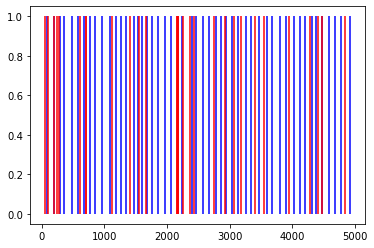

In [145]:
# Test parameter valeus

T = 100
sigma = 20
Lambda = 0.005
N = 50
x = 0 
z = 0

periodic_series = []
noise_series = []
for _ in range(N):
    
    # sample periodic signal timestamp
    while True: 
        # N.B. ensure our new sample xnew > x
        # otherwise sample again until we satisfy this. 
        dper = norm.rvs(loc=T, scale=sigma, size=1)[0]
        xnew = x + dper
        if (xnew > x):
            x = xnew
            periodic_series.append(xnew)
            break
    
while True:  
    dnoise = expon.rvs(loc=0, scale=1/Lambda, size=1)[0]
    z += dnoise
    if z > periodic_series[-1]:
        break
    noise_series.append(z)

signal_timestamps = sorted(periodic_series + noise_series)
rng_xmax = min([noise_series[-1], periodic_series[-1]])
plt.figure()
plt.vlines(periodic_series, color='b', ymin=0, ymax=1)
plt.vlines(noise_series, color='r', ymin=0, ymax=1)

In [149]:
conf = Config(signal=signal_timestamps, num_particles=1000)
model = PeriodicityParticleFilter(conf)

res = model.fit()

res

Particles(T=array([ 6926.96578168,  7001.68901054,  6980.83183549,  6976.04323588,
        6906.19236919,  6880.71174692,  7036.47714951,  6930.43759844,
        6890.60169996,  7036.6583784 ,  7040.72457031,  6952.05647177,
        6926.64878625,  6955.55280255,  6906.52774468,  7080.65366516,
        6968.66803753,  6925.90846494,  6921.88108802,  6928.67137246,
        6980.66034827,  6918.32811776,  6910.53581273,  6945.14165961,
        6907.85271616,  6982.00098338,  6884.20965704,  6922.27655422,
        6964.87560757,  6972.92513743,  6927.16222615,  6905.62763145,
        6941.22161875,  6706.72676724,  6868.26501913,  6879.44370127,
        6979.77542845,  7519.35690137,  6956.76981692,  6952.24359077,
        6926.0977727 ,  6916.53507323,  6913.72654664,  6918.80512791,
        6923.57309944,  7110.56224801,  6913.22997804,  6914.87118976,
        6919.69674825,  6438.0207191 ,  6938.46124816,  6978.93542157,
        6921.96401723,  6829.75674034,  6928.99462262,  6868.2650

Text(0.5, 1.0, 'Z distribution')

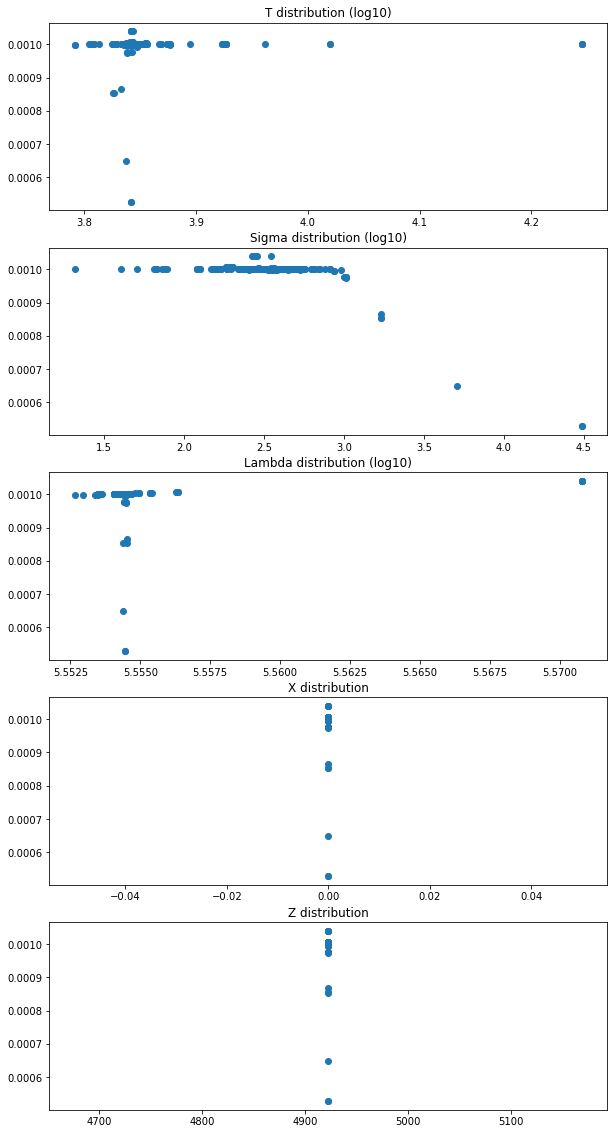

In [157]:
idx = -1

h = debugInfo.h_series[idx]
lw = debugInfo.L_series[idx]

fig, ax = plt.subplots(5, figsize=(10,20))
ax[0].scatter(np.log10(h.T), lw)
ax[1].scatter(np.log10(h.Sigma), lw)
ax[2].scatter(np.log10(h.Lambda), lw)
ax[3].scatter(h.X, lw)
ax[4].scatter(h.Z, lw)
ax[0].set_title('T distribution (log10)')
ax[1].set_title('Sigma distribution (log10)')
ax[2].set_title('Lambda distribution (log10)')
ax[3].set_title('X distribution')
ax[4].set_title('Z distribution')

40.38625081872222
15.336646415040246
8773.64988453779


Text(0.5, 1.0, 'Lambda distribution (log10)')

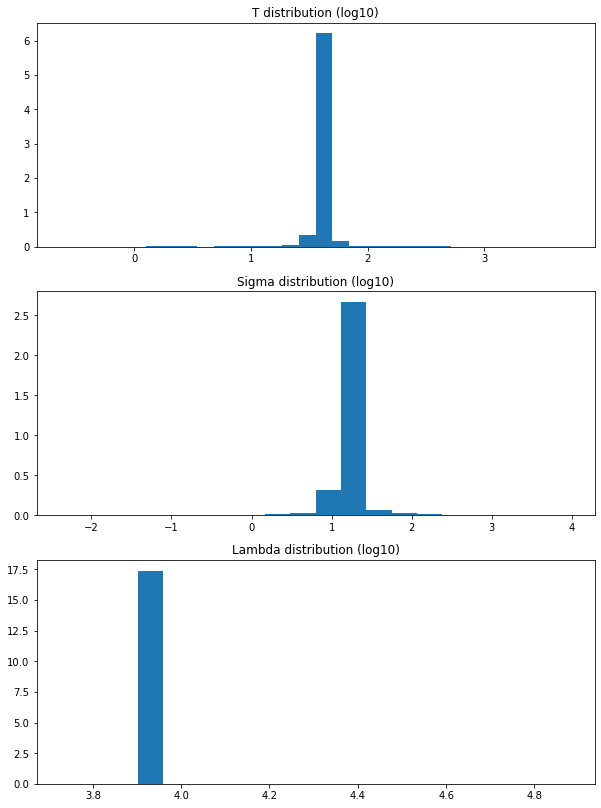

In [49]:
fig, ax = plt.subplots(3, figsize=(10,14))
idx = 5

h = debugInfo.h_series[idx]
print(np.median(h.T))
print(np.median(h.Sigma))
print(np.median(h.Lambda))

ax[0].hist(np.log10(h.T), bins=30, density=True)
ax[1].hist(np.log10(h.Sigma), bins=20, density=True)
ax[2].hist(np.log10(h.Lambda), bins=20, density=True)
ax[0].set_title('T distribution (log10)')
ax[1].set_title('Sigma distribution (log10)')
ax[2].set_title('Lambda distribution (log10)')

(array([199., 158., 122., 105.,  82.,  57.,  59.,  41.,  35.,  35.,  19.,
         18.,  12.,  11.,   8.,   7.,   7.,   5.,   3.,   3.,   2.,   5.,
          1.,   0.,   2.,   1.,   0.,   2.,   0.,   1.]),
 array([6.18069760e-03, 1.06639630e+01, 2.13217453e+01, 3.19795276e+01,
        4.26373098e+01, 5.32950921e+01, 6.39528744e+01, 7.46106567e+01,
        8.52684390e+01, 9.59262213e+01, 1.06584004e+02, 1.17241786e+02,
        1.27899568e+02, 1.38557350e+02, 1.49215133e+02, 1.59872915e+02,
        1.70530697e+02, 1.81188480e+02, 1.91846262e+02, 2.02504044e+02,
        2.13161826e+02, 2.23819609e+02, 2.34477391e+02, 2.45135173e+02,
        2.55792956e+02, 2.66450738e+02, 2.77108520e+02, 2.87766302e+02,
        2.98424085e+02, 3.09081867e+02, 3.19739649e+02]),
 <a list of 30 Patch objects>)

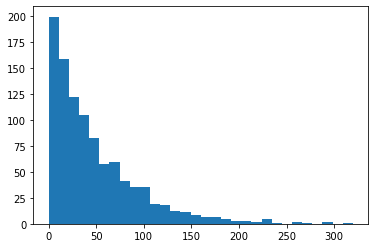

In [10]:
y = np.random.exponential(50, 1000)

plt.hist(y, bins=30)

In [95]:
h.Z

array([0., 0., 0., ..., 0., 0., 0.])